# T-Pot Results

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import json
import pycountry
import matplotlib.dates as mdates
import time
plt.style.use('ggplot')

## Attack distribution

In [50]:
df = pd.read_csv("./data/tpot-overview-attacks.csv")
df = df.sort_values(by=['Honeypots'])
df.head()

,Honeypots,Attacks
0,Adbhoney,11482
1,Ciscoasa,885
2,CitrixHoneypot,1409
3,ConPot,764
4,Cowrie,93672


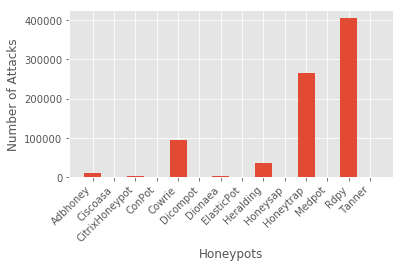

In [51]:
x = df['Honeypots'].to_numpy()
y = df['Attacks'].to_numpy()

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y)

plt.ylabel("Number of Attacks")
plt.xlabel("Honeypots")

plt.gcf().subplots_adjust(bottom=0.30, left=0.15)
plt.xticks(x_pos, x)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig("tpot-overview-attacks.pdf", format="pdf")

plt.show()

## Attack Map

In [3]:
from shapely.geometry import Point

In [4]:
df = pd.read_csv("./data/tpot-overview-map.csv")
geos = df["Geo Centroid"].to_numpy()
lats = []
lons = []
for geo in geos:
    test = json.loads(geo)
    lats.append(test["lat"])
    lons.append(test["lon"])
df["Longitude"] = lons
df["Latitude"] = lats
df.head()

,Filter,Geohash,Count,Geo Centroid,Longitude,Latitude
0,undefined,u0,"115,524","{\n ""lat"": 49.604705879418674,\n ""lon"": 7.56...",7.566805,49.604706
1,undefined,u1,"102,260","{\n ""lat"": 51.84559343054909,\n ""lon"": 7.150...",7.150243,51.845593
2,undefined,9y,"90,068","{\n ""lat"": 37.75120567644529,\n ""lon"": -97.8...",-97.820118,37.751206
3,undefined,uc,"63,472","{\n ""lat"": 55.73067623077615,\n ""lon"": 37.60...",37.608510,55.730676
4,undefined,dr,"33,270","{\n ""lat"": 42.164332152348905,\n ""lon"": -71....",-71.900391,42.164332


In [5]:
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry=geometry)

In [7]:
df = pd.read_csv("./data/tpot-attacks-country.csv")
country_name = {}
for country in pycountry.countries:
    country_name[country.name] = country.alpha_3
    if hasattr(country, 'common_name'):
        country_name[country.common_name] = country.alpha_3
    if hasattr(country, 'official_name'):
        country_name[country.official_name] = country.alpha_3
    if hasattr(country, 'numeric'):
        country_name[country.numeric] = country.alpha_3
codes = []
for country in df["Country"]:
    code = country_name.get(country, 'Unknown code')
    if code == 'Unknown code':
        print(country)
    codes.append(code)
df["iso_a3"] = codes
df.head()

,Country,Count,iso_a3
0,United States,204590,USA
1,Germany,119500,DEU
2,Russian Federation,94877,RUS
3,Netherlands,52087,NLD
4,China,44240,CHN


In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world = pd.merge(world, df, on='iso_a3')
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Country,Count
0,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974...",Canada,2874
1,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49....",United States,204590
2,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997033076265 49.21498078062912,...",Kazakhstan,43
3,260580739,Asia,Indonesia,IDN,3028000.0,(POLYGON ((141.0002104025918 -2.60015105551566...,Indonesia,4376
4,44293293,South America,Argentina,ARG,879400.0,(POLYGON ((-68.63401022758323 -52.636370458874...,Argentina,191


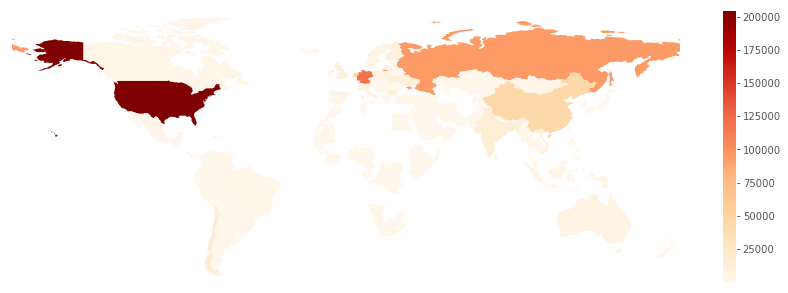

In [9]:
fig, ax = plt.subplots(figsize = (15, 5))
world.plot(ax=ax, column="Count", cmap='OrRd', legend=True)
ax.set_facecolor('white')
# geo_df.plot(ax=ax)

plt.xticks([])
plt.yticks([])
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

fig.savefig("tpot-overview-map.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

## Attack histogram

In [235]:
df = pd.read_csv("./data/tpot-attacks-histogram.csv")
df.Attacks = df.Attacks.str.replace(',', '').astype(int)
df.Timestamp = pd.to_datetime(df.Timestamp)
df.head()

,type,Timestamp,Attacks
0,Rdpy,2021-09-27 12:00:00,24
1,Rdpy,2021-09-28 00:00:00,261
2,Rdpy,2021-09-28 12:00:00,34474
3,Rdpy,2021-09-29 00:00:00,3153
4,Rdpy,2021-09-29 12:00:00,7640


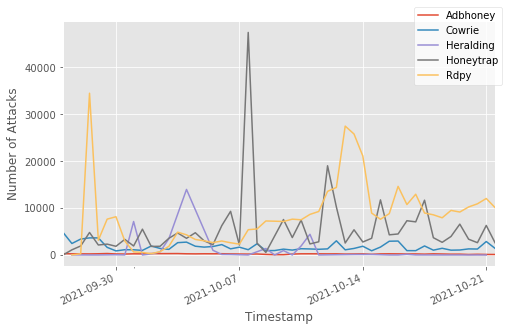

In [236]:
fig, ax = plt.subplots(figsize = (8,5))

for k, d in df.groupby('type'):
    x = d['Timestamp'].to_numpy()
    y = d['Attacks'].to_numpy()
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    
    ax.plot(x,y, label=k)


fig.autofmt_xdate()
ax.set_ylabel("Number of Attacks")
ax.set_xlabel("Timestamp")

# Major ticks every 6 months.
fmt_half_year = mdates.DayLocator(interval=7)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Round to nearest years.
datemin = df.Timestamp.min()
datemax = df.Timestamp.max()
ax.set_xlim(datemin, datemax)

# Put a legend to the right of the current axis
legend = plt.legend(loc='center left', bbox_to_anchor=(0.8, 0.9), frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xticks( rotation=25 )
plt.gcf().subplots_adjust(left=0.15)
plt.savefig("tpot-attacks-histogram.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

## Suricata

In [191]:
df = pd.read_csv("./data/tpot-suricata-alert.csv")
df.Attacks = df.Attacks.str.replace(',', '').astype(int)
df.Timestamp = pd.to_datetime(df.Timestamp)
#df = df.sort_values(by=["alert", "Timestamp"])
df.head()

,alert,Timestamp,Attacks
0,Misc activity,2021-09-22 00:00:00,137
1,Misc activity,2021-09-22 12:00:00,192
2,Misc activity,2021-09-23 00:00:00,136
3,Misc activity,2021-09-23 12:00:00,164
4,Misc activity,2021-09-24 00:00:00,130


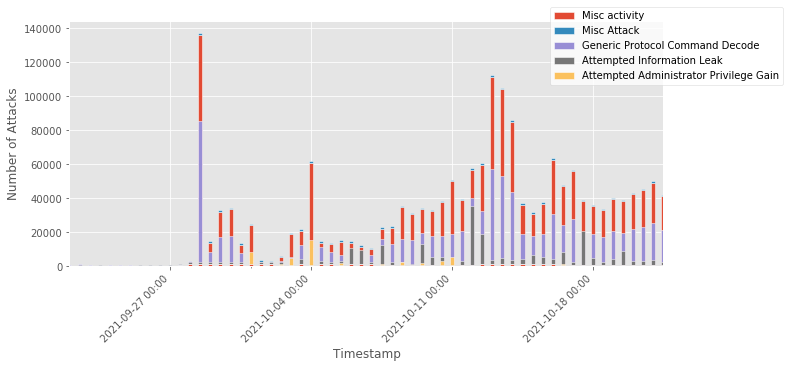

In [234]:
fig, ax = plt.subplots(figsize = (15,5))

x_pos = [i for i, _ in enumerate(df.groupby("Timestamp"))]

bottoms=[]
for idx, (k, d) in reversed(list(enumerate(df.groupby("alert")))):
    x = d["Timestamp"]
    y = d["Attacks"]
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))
    
    if idx == 4:
        ax.bar(x, y, 0.2, edgecolor='white',label=k)
    else:
        ax.bar(x, y, 0.2,bottom=bottoms[idx-3] ,edgecolor='white',label=k)
    
    bottoms.append(y.to_numpy())

fig.autofmt_xdate()
plt.ylabel("Number of Attacks")
plt.xlabel("Timestamp")

# Major ticks every 6 months.
fmt_half_year = mdates.DayLocator(interval=7)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

# Round to nearest years.
datemin = df.Timestamp.min()
datemax = df.Timestamp.max()
ax.set_xlim(datemin, datemax)

# Put a legend to the right of the current axis
legend = plt.legend(loc='center left', bbox_to_anchor=(0.8, 0.9), frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xticks( rotation=25 )
plt.gcf().subplots_adjust(left=0.35)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig("tpot-suricata-alerts.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()